In [122]:
import sys
sys.path.append('../..')

In [123]:
import pathlib

import numpy
import numpy.fft

import scipy.signal

import PIL.Image

import lasp.io
import lasp.filters.linear
import lasp.utils
import lasp.noise

In [124]:
import scipy.io.matlab

def cmp_py_mat(var_name: str, var_py) -> None:
    mat = scipy.io.matlab.loadmat(pathlib.Path('./{}.mat'.format(var_name)))
    matlab = mat[var_name]
    print(var_name, ':', numpy.max(numpy.abs(var_py-matlab)))
datas = {}

In [125]:
refl = lasp.io.read(pathlib.Path('lena.bmp'))
# refl = numpy.ones(shape=(4, 4))
datas['refl'] = numpy.copy(refl)

In [126]:
B = lasp.filters.linear.gaussian_filter(7, 3)
datas['B'] = numpy.copy(B)


nb_rows, nb_cols = B.shape
kernel_padded = numpy.zeros(refl.shape)
kernel_padded[:nb_rows, :nb_cols] = numpy.copy(B)
center = numpy.floor(numpy.array(B.shape)/2).astype(int) + 1
circshifted = lasp.utils.circshift(kernel_padded, 1-center)

FB = numpy.fft.fft2(circshifted)
datas['FB'] = numpy.copy(FB)

# HXconv
#FB = fourier_diagonalization(B, refl.shape)
FBC = numpy.conj(FB)
datas['FBC'] = numpy.copy(FB)
F2B = numpy.abs(FB)**2
datas['F2B'] = numpy.copy(FB)
print(FB.shape, FBC.shape, F2B.shape)

#Bx n'a d'intêret que pour le bruitage du signal
#Bx = numpy.real(FB*numpy.fft.fft2(refl))

(512, 512) (512, 512) (512, 512)


In [127]:
# cmp_py_mat('FB', FB)
# cmp_py_mat('FBC', FBC)
# cmp_py_mat('F2B', F2B)

In [128]:
# On saute la partie bruitage
# Dans le code matlab, la décimation s'effectue après le bruitage
## Bruiter le signal en python
#snr = 10
Bx = scipy.signal.convolve2d(refl, B, mode='same')
#y = lasp.noise.awgn(Bx, snr)
#y = Bx
y = numpy.copy(Bx)
datas['y'] = numpy.copy(y)

In [129]:
def decimation(image: numpy.ndarray, d_row: int, d_col: int) -> numpy.ndarray:
    if d_row <= 0:
        raise AssertionError('d_row <= 0')
    if d_col <= 0:
        raise AssertionError('d_col <= 0')
    return numpy.copy(image[0::d_row, 0::d_col])

d = 4
datas['d'] = d
dr = d
dc = d
y = decimation(y, dr, dc)

yinp = numpy.array(
   PIL.Image.Image.resize(
       PIL.Image.fromarray(y), 
       (refl.shape[1], refl.shape[0]), 
       PIL.Image.Resampling.BICUBIC
   ),
   dtype=numpy.double
)
# yinp = refl.copy()

datas['yinp'] = numpy.copy(yinp)

In [130]:
tau = 2e-3
datas['tau'] = tau
nr, nc = y.shape
nrup, ncup = nr*d, nc*d
Nb = dr*dc
m = nr*nc

In [131]:
tol = 1e-3
maxiter = 100
datas['tol'] = tol
datas['maxiter'] = maxiter

In [132]:
mu = 5e-3
datas['mu'] = mu
gam = tau/mu

In [133]:
dh = numpy.zeros(shape=(nrup, ncup))
dh[0, 0] = 1
dh[0, 1] = -1

dv = numpy.zeros(shape=(nrup, ncup))
dv[0, 0] = 1
dv[1, 0] = -1

print(dh.shape, dv.shape)

(512, 512) (512, 512)


In [134]:
FDH = numpy.fft.fft2(dh).astype(numpy.complex128)
FDHC = numpy.conj(FDH).astype(numpy.complex128)
F2DH = (numpy.abs(FDH)**2).astype(numpy.complex128)

FDV = numpy.fft.fft2(dv).astype(numpy.complex128)
FDVC = numpy.conj(FDV).astype(numpy.complex128)
F2DV = (numpy.abs(FDV)**2)

c = 1e-8
F2D = F2DH + F2DV + c

In [135]:
# cmp_py_mat('FDH', FDH)
# cmp_py_mat('FDHC', FDHC)
# cmp_py_mat('F2DH', F2DH)
# print()
# cmp_py_mat('FDV', FDV)
# cmp_py_mat('FDVC', FDVC)
# cmp_py_mat('F2DV', F2DV)
# print()
# cmp_py_mat('F2D', F2D)

In [136]:
STy = numpy.zeros(shape=(nrup, ncup))
STy[0::d, 0::d] = y

FBTSTy = FBC * numpy.fft.fft2(STy)

In [137]:
# cmp_py_mat('STy', STy)
# cmp_py_mat('FBTSTy', FBTSTy)

In [138]:
X = numpy.copy(yinp)
FX = numpy.fft.fft2(X)
#BX = numpy.fft.ifft2(FB*numpy.fft.fft2(X))
BX = numpy.real(numpy.fft.ifft2(FB*FX))

In [139]:
# cmp_py_mat('X', X)
# #cmp_py_mat('FX', FX)
# cmp_py_mat('BX', BX)

In [141]:
# INVLS
import typing

def blockproc_reshape(
    array: numpy.ndarray,
    block_size: numpy.ndarray
) -> numpy.ndarray:

    nb_rows, nb_cols = array.shape
    res = None

    step_r, step_c = block_size

    for i in range(0, nb_rows, step_r):

        column = None
        
        for j in range(0, nb_cols, step_c):
            bloc = numpy.reshape(
                array[i:i+step_r, j:j+step_c], 
                (step_r*step_c, 1),
                order='F'
            )
            if column is None:
                column = numpy.copy(bloc)
            else:
                column = numpy.vstack([ column, bloc ])

        if res is None:
            res = numpy.copy(column)
        else:
            res = numpy.hstack([ res, column ])

    return res

def blockproc(
    array: numpy.ndarray, 
    block_shape: numpy.ndarray,
    fun: typing.Callable[[numpy.ndarray], numpy.ndarray]
) -> numpy.ndarray:
    
    nb_rows, nb_cols = array.shape
    step_r, step_c = block_shape
    
    for i in range(0, nb_rows, step_r):
        for j in range(0, nb_cols, step_c):
            array[i:i+step_r, j:j+step_c] = \
                fun(array[i:i+step_r, j:j+step_c])
    
    return array
                
def block_mm(nr, nc, Nb, x1) -> numpy.ndarray:

    block_shape = numpy.array([nr, nc])
    x1 = blockproc_reshape(x1, block_shape)
    x1 = numpy.reshape(x1, newshape=(nr*nc, Nb), order='F')
    x1 = numpy.sum(x1, axis=1)
    x = numpy.reshape(x1, newshape=(nr, nc), order='F')

    return x

##########


X = numpy.copy(yinp)
FX = numpy.fft.fft2(X)
#BX = numpy.fft.ifft2(FB*numpy.fft.fft2(X))
BX = numpy.real(numpy.fft.ifft2(FB*FX))

U1 = numpy.copy(X)
U2 = numpy.copy(X)

D1 = numpy.zeros_like(X)
D2 = numpy.zeros_like(X)

for i in range(0, maxiter):

    # Update X
    V1 = U1-D1
    V2 = U2-D2

    FV1 = mu*FDHC*numpy.fft.fft2(V1)
    FV2 = mu*FDVC*numpy.fft.fft2(V2)
    FR = FBTSTy + FV1 + FV2

    ## INVLS
    FBFR = FB*FR
    FBFR_F2D = FBFR / F2D
    x1 = FB*FR / F2D
    FBR = block_mm(nr, nc, Nb, x1)
    invW = block_mm(nr, nc, Nb, F2B / F2D)
    invWBR = FBR / (invW + mu * Nb)
    fun = lambda block : block*invWBR
    FCBinvWBR = blockproc(numpy.copy(FBC), numpy.array([nr, nc]), fun)
    ### Return
    FX = (FR-FCBinvWBR) / F2D / mu
    X = numpy.real(numpy.fft.ifft2(FX))

    ########
    # Update U
    #DhX = numpy.fft.ifft2(FX*FDH)
    #DvX = numpy.fft.ifft2(FX*FDV)
    DhX = numpy.real(numpy.fft.ifft2(FX*FDH))
    DvX = numpy.real(numpy.fft.ifft2(FX*FDV))
    NU1 = DhX + D1
    NU2 = DvX + D2
    NU = numpy.sqrt(NU1**2 + NU2**2)
    A = numpy.where(0 < NU-gam, NU-gam, 0)
    A = A / (A + gam)
    U1 = A*NU1
    U2 = A*NU2

    # Update D
    D1 = D1 + (DhX - U1)
    D2 = D2 + (DvX - U2)

X = numpy.real(numpy.fft.ifft2(FX))

In [142]:
#print(FBR_hist[0][0:5, 0:5])
#print(invW_hist[0][0:5, 0:5])
#print(invWBR_hist[0][0:5, 0:5])
#print(FCBinvWBR_hist[0][0:5, 0:5])
#print(FX_hist[0][0:5, 0:5])
#print(FX_hist[0][1, 0])
#FX_hist


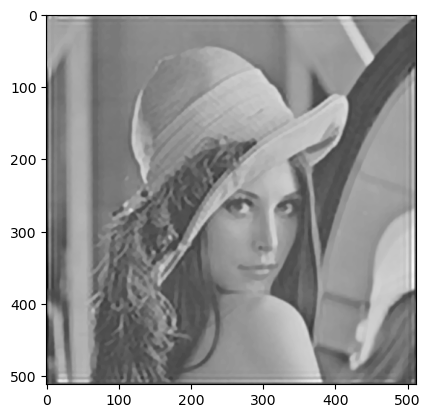

In [143]:
import matplotlib.pyplot
_ = matplotlib.pyplot.imshow(X, cmap='gray')

In [144]:
scipy.io.matlab.savemat('datas.mat', datas)